# <a>Project 6 - Transfer Learning with Pytorch</a>

## Let's Data - Data Science Journey

*By Reginaldo Jr - <a>reginaldojr@yahoo.com</a>*

### Imports and Configurations

In [66]:
import numpy as np
import os
import PIL.Image
import time
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import shutil
import seaborn as sns
import pandas as pd
import gradio as gr

from matplotlib import pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from IPython.display import Image

### Data

In [67]:
base_path = './data'
classes = os.listdir(os.path.join(base_path, "raw"))
classes

['carrot', 'lemon', 'potato', 'tomato']

In [68]:
qtd_by_classes = dict()
for folder in classes:
    qtd_by_classes[folder]=len(os.listdir(os.path.join(base_path, "raw",folder))) 
qtd_by_classes

{'carrot': 181, 'lemon': 111, 'potato': 146, 'tomato': 107}

In [69]:
processed_path = os.path.join(base_path, "processed")
if not os.path.exists(processed_path):
    os.makedirs(processed_path)
else:
    print("Processed folder already exists.")

In [70]:
train_folder = os.path.join(processed_path, "train")
val_folder = os.path.join(processed_path, "val")
test_folder = os.path.join(processed_path, "test")

if not os.path.exists(train_folder):
    os.makedirs(train_folder)
else:
    print("Train folder already exists.")
    
if not os.path.exists(val_folder):
    os.makedirs(val_folder)
else:
    print("Validation folder already exists.")
    
if not os.path.exists(test_folder):
    os.makedirs(test_folder)
else:
    print("Test folder already exists.")

In [71]:
folders = [train_folder, val_folder, test_folder]
for cl in classes:
    for folder in folders:
        dir_cl = os.path.join(folder,cl)
        if not os.path.exists(dir_cl):
            os.makedirs(dir_cl)
              
    files_in_class = os.listdir(os.path.join(base_path, "raw",cl))
    train, test = train_test_split(files_in_class, test_size=.2, random_state=42)
    val, test = train_test_split(test, test_size=.5, random_state=42)
    print(cl, len(train),len(val),len(test))
    print("Coping...")
    for i,files in enumerate((train, val, test)):
        folder = folders[i]
        for file in files:
            source = os.path.join(os.path.join(base_path, "raw"), cl, file)
            target = os.path.join(folder, cl, file)            
            shutil.copy(source, target)
print("Done!")

carrot 144 18 19
Coping...
lemon 88 11 12
Coping...
potato 116 15 15
Coping...
tomato 85 11 11
Coping...
Done!


### Preprocessing

In [72]:
image_size = 100
batch_size=8
classes_number = len(classes)

In [73]:
image_transformations = {
    'train': transforms.Compose([transforms.Resize(size=[image_size, image_size]), transforms.ToTensor()]),
    'val': transforms.Compose([transforms.Resize(size=[image_size, image_size]), transforms.ToTensor()]),
    'test': transforms.Compose([transforms.Resize(size=[image_size, image_size]), transforms.ToTensor()]),    
}

In [74]:
train_folder, val_folder, test_folder

('./data\\processed\\train',
 './data\\processed\\val',
 './data\\processed\\test')

In [75]:
data = {
    "train": datasets.ImageFolder(root=train_folder, transform=image_transformations["train"]),
    "val": datasets.ImageFolder(root=val_folder, transform=image_transformations["val"])    
}
data

{'train': Dataset ImageFolder
     Number of datapoints: 433
     Root location: ./data\processed\train
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 55
     Root location: ./data\processed\val
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            )}

In [76]:
len(data["train"])

433

In [77]:
train_dataloader = DataLoader(data["train"], batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(data["val"], batch_size=batch_size, shuffle=True)

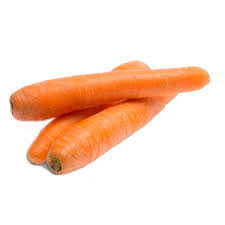

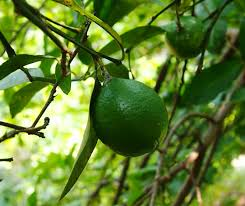

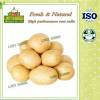

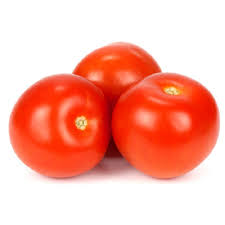

In [78]:
for cl in classes:
    folder = os.path.join(train_folder,cl)
    file = os.listdir(folder)[1]
    image = Image(filename=os.path.join(folder,file))
    display(image)

### Model

In [79]:
model = models.alexnet(weights='IMAGENET1K_V1')
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [80]:
type(model)

torchvision.models.alexnet.AlexNet

In [81]:
[p  for p in model.parameters()]

[Parameter containing:
 tensor([[[[ 1.1864e-01,  9.4069e-02,  9.5435e-02,  ...,  5.5822e-02,
             2.1575e-02,  4.9963e-02],
           [ 7.4882e-02,  3.8940e-02,  5.2979e-02,  ...,  2.5709e-02,
            -1.1299e-02,  4.1590e-03],
           [ 7.5425e-02,  3.8779e-02,  5.4930e-02,  ...,  4.3596e-02,
             1.0225e-02,  1.3251e-02],
           ...,
           [ 9.3155e-02,  1.0374e-01,  6.7547e-02,  ..., -2.0277e-01,
            -1.2839e-01, -1.1220e-01],
           [ 4.3544e-02,  6.4916e-02,  3.6164e-02,  ..., -2.0248e-01,
            -1.1376e-01, -1.0719e-01],
           [ 4.7369e-02,  6.2543e-02,  2.4758e-02,  ..., -1.1844e-01,
            -9.5567e-02, -8.3890e-02]],
 
          [[-7.2634e-02, -5.7996e-02, -8.0661e-02,  ..., -6.0304e-04,
            -2.5309e-02,  2.5471e-02],
           [-6.9042e-02, -6.7562e-02, -7.6367e-02,  ..., -3.9616e-03,
            -3.0402e-02,  1.0477e-02],
           [-9.9517e-02, -8.5592e-02, -1.0521e-01,  ..., -2.6587e-02,
            -2.2

In [82]:
for p in model.parameters():
    p.requires_grad=False

model.classifier[6]=nn.Linear(4096, classes_number)
model.classifier[6]

Linear(in_features=4096, out_features=4, bias=True)

In [83]:
model.classifier.add_module("7", nn.LogSoftmax(dim=1))
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [84]:
[p  for p in model.classifier[6].parameters()]

[Parameter containing:
 tensor([[-3.5937e-03,  6.7445e-03, -4.0503e-03,  ...,  4.2444e-03,
           3.5882e-03, -1.4326e-02],
         [ 2.0122e-03, -1.9143e-03, -9.8653e-03,  ..., -3.6612e-03,
           1.0307e-02,  8.5298e-03],
         [ 7.3989e-03, -6.9577e-03, -9.9101e-03,  ...,  1.1484e-02,
           7.1070e-03,  1.3027e-02],
         [ 1.5227e-04,  1.2619e-02, -7.5282e-04,  ..., -4.5835e-03,
          -1.2331e-06, -9.1079e-03]], requires_grad=True),
 Parameter containing:
 tensor([-0.0093, -0.0048, -0.0086,  0.0087], requires_grad=True)]

In [85]:
error_function = nn.CrossEntropyLoss()
display(error_function)
optimizer = optim.Adam(model.parameters())
display(optimizer)

CrossEntropyLoss()

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

### Train and Validate

In [86]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def TrainValidate(model, error_function, optimizer, epochs=10):
    history = []
    best_accuracy = 0.
    best_model = None
        
    for epoch in range(epochs):
        start = time.time()
        print (f"\n\nEpoch: {epoch+1}/{epochs}")
        
        train_error = 0.
        train_hit = 0.        
        val_error = 0.
        val_hit = 0.
        
        for i, (batch_images, y_real) in enumerate(train_dataloader):
            batch_images = batch_images.to(device)
            y_real = y_real.to(device)
                       
            optimizer.zero_grad()
            
            pred = model(batch_images)
                        
            #print(batch_images.size())
            #print(pred)
            #print(torch.exp(pred))
            #print(torch.max(pred.data,1))
            #print(y_real)

            
            error = error_function(pred, y_real)
            error.backward()            
            optimizer.step()
            
            train_error += error.item() * batch_images.size(0)
            
            _,pred_class = torch.max(pred.data,1)
            hit_pred = (pred_class==y_real).type(torch.FloatTensor)   
            train_hit += torch.sum(hit_pred)
            
        with torch.no_grad():
            model.eval()
            for j, (batch_images, y_real) in enumerate(val_dataloader):
                batch_images = batch_images.to(device)
                y_real = y_real.to(device)
                
                pred = model(batch_images)
                
                error = error_function(pred, y_real)                
                val_error += error.item() * batch_images.size(0)
                
                _,pred_class = torch.max(pred.data,1)
                hit_pred = (pred_class==y_real).type(torch.FloatTensor)            
                val_hit += torch.sum(hit_pred)
        
        history.append([train_error/len(data["train"]), val_error/len(data["val"]), train_hit/len(data["train"]), val_hit/len(data["val"])])
        
        end = time.time()
        print(f"Train: Error: {history[-1][0]:.4f} Accuracy: {history[-1][2]*100:.4f}, Validation: Error: {history[-1][1]:.4f} Accuracy: {history[-1][3]*100:.4f}")
        
        if history[-1][3] > best_accuracy:
            best_accurary = history[-1][3]
            best_model = model
    
    return best_model, history           

cpu


In [87]:
model, history = TrainValidate(model, error_function, optimizer, epochs=10)



Epoch: 1/10
Train: Error: 0.3297 Accuracy: 88.4527, Validation: Error: 0.1328 Accuracy: 94.5455


Epoch: 2/10
Train: Error: 0.0398 Accuracy: 98.6143, Validation: Error: 0.0603 Accuracy: 98.1818


Epoch: 3/10
Train: Error: 0.0133 Accuracy: 99.7691, Validation: Error: 0.0659 Accuracy: 96.3636


Epoch: 4/10
Train: Error: 0.0130 Accuracy: 99.5381, Validation: Error: 0.0767 Accuracy: 96.3636


Epoch: 5/10
Train: Error: 0.0035 Accuracy: 100.0000, Validation: Error: 0.0850 Accuracy: 96.3636


Epoch: 6/10
Train: Error: 0.0022 Accuracy: 100.0000, Validation: Error: 0.0776 Accuracy: 96.3636


Epoch: 7/10
Train: Error: 0.0016 Accuracy: 100.0000, Validation: Error: 0.0729 Accuracy: 96.3636


Epoch: 8/10
Train: Error: 0.0014 Accuracy: 100.0000, Validation: Error: 0.0710 Accuracy: 96.3636


Epoch: 9/10
Train: Error: 0.0012 Accuracy: 100.0000, Validation: Error: 0.0712 Accuracy: 96.3636


Epoch: 10/10
Train: Error: 0.0011 Accuracy: 100.0000, Validation: Error: 0.0758 Accuracy: 96.3636


In [88]:
history

[[0.32973791822498316, 0.13284105887128547, tensor(0.8845), tensor(0.9455)],
 [0.03976239883136563, 0.06030172197656198, tensor(0.9861), tensor(0.9818)],
 [0.013281813090117046, 0.06587091113694689, tensor(0.9977), tensor(0.9636)],
 [0.013042128927675572, 0.07668961082288826, tensor(0.9954), tensor(0.9636)],
 [0.0034806179433876077, 0.08503062777559865, tensor(1.), tensor(0.9636)],
 [0.0021780086386847734, 0.07761856802866202, tensor(1.), tensor(0.9636)],
 [0.0016413725103712996, 0.07292872182178227, tensor(1.), tensor(0.9636)],
 [0.0014072615027107196, 0.07097365876490419, tensor(1.), tensor(0.9636)],
 [0.0012139764970101794, 0.0712407899512486, tensor(1.), tensor(0.9636)],
 [0.0010876937834013631, 0.07578876804063012, tensor(1.), tensor(0.9636)]]

In [89]:
df = pd.DataFrame({"Train error":np.array(history)[:,0], "Validation error":np.array(history)[:,1], 
                   "Train accuracy":np.array(history)[:,2], "Validation accuracy":np.array(history)[:,3]})
df

,Train error,Validation error,Train accuracy,Validation accuracy
0,0.329738,0.132841,0.884527,0.945455
1,0.039762,0.060302,0.986143,0.981818
2,0.013282,0.065871,0.997691,0.963636
3,0.013042,0.076690,0.995381,0.963636
4,0.003481,0.085031,1.000000,0.963636
5,0.002178,0.077619,1.000000,0.963636
6,0.001641,0.072929,1.000000,0.963636
7,0.001407,0.070974,1.000000,0.963636
8,0.001214,0.071241,1.000000,0.963636
9,0.001088,0.075789,1.000000,0.963636


(0.0, 1.0)

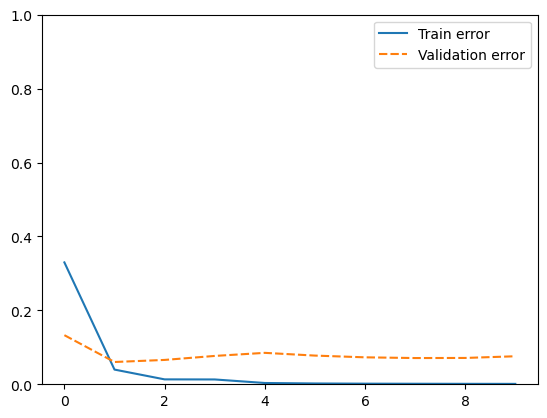

In [90]:
sns.lineplot(df[["Train error","Validation error"]])
plt.ylim(0,1)

(0.0, 1.0)

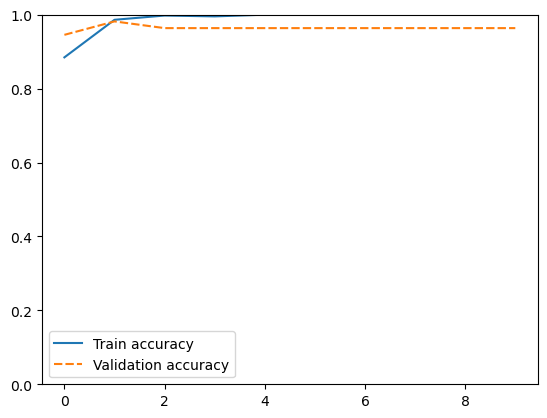

In [91]:
sns.lineplot(df[["Train accuracy","Validation accuracy"]])
plt.ylim(0,1)

### Test

In [92]:
def predict_image(image):
    transformation = image_transformations["test"]
    tensor = transformation(image)
    
    if torch.cuda.is_available():
        tensor = tensor.view(1,3,image_size, image_size).cuda()
    else:
        tensor = tensor.view(1,3,image_size, image_size)
        
    my_pred = {}
    with torch.no_grad():
        model.eval()
        pred = model(tensor)        
        pred = torch.exp(pred)
        
        my_pred = {cl: float(pred[0][i]) for i,cl in enumerate(classes)}
          
    return my_pred

'tomato'

'lemon'

'potato'

'tomato'

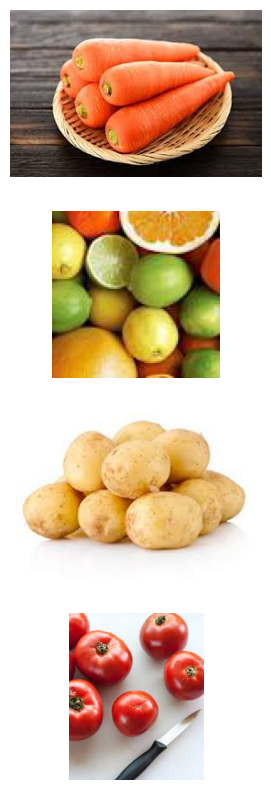

In [93]:
fig, graph = plt.subplots(nrows=len(classes), ncols=1, figsize=(5, 10))

for i, cl in enumerate(classes):
    folder = os.path.join(test_folder, cl)
    image_path = os.path.join(folder, os.listdir(folder)[4])
    image = PIL.Image.open(image_path)

    graph[i].imshow(image)
    #graph[i].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
   
    graph[i].axis('off')    
    
    pred = predict_image(image)
    
    display(max(pred, key=pred.get))    

In [94]:
hits = 0
image_total = 0
for cl in classes:
    folder = os.path.join(test_folder, cl)
    image_total += len(os.listdir(folder))
    for image in os.listdir(folder):
        image_path = os.path.join(folder, image)
        image = PIL.Image.open(image_path)
        pred = predict_image(image)
        
        if max(pred, key=pred.get)==cl:
            hits += 1
print ("Test accuracy: ", hits / image_total * 100)      

Test accuracy:  96.49122807017544


In [95]:
interface = gr.Interface(fn=predict_image,
                        inputs=gr.components.Image(type='pil'),
                        outputs="label").launch(share=False)

Running on local URL:  http://127.0.0.1:7868

To create a public link, set `share=True` in `launch()`.
